In [3]:
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Activation, Flatten,Dropout,Conv2D,MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential
import pickle
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
batch_size = 128

In [5]:
DATADIR = r'/kaggle/input/mrl-eye-dataset/data/train'

CATEGORIES = ["close eyes", "open eyes"]

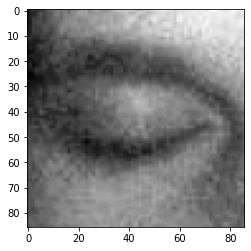

[[ 67  70  72 ... 101 102 104]
 [ 64  67  68 ...  98 100 101]
 [ 65  67  69 ...  98  99 100]
 ...
 [ 77  79  78 ...  77  78  80]
 [ 77  79  79 ...  76  78  80]
 [ 75  77  79 ...  76  78  80]]


In [6]:
for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        
        break  # we just want one for now so break
    break  #...and one more!
print(img_array)

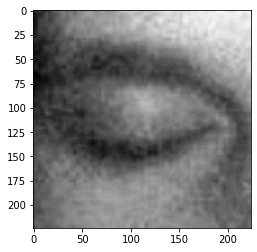

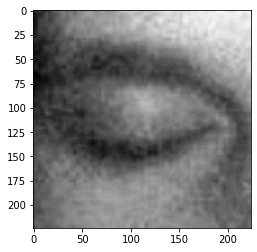

In [7]:
IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()
training_data = []

In [8]:
train_datagen= ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2, validation_split=0.2,horizontal_flip=True,vertical_flip=True)
train_data= train_datagen.flow_from_directory(r'/kaggle/input/mrl-eye-dataset/data/train',
                                target_size=(224,224),batch_size=batch_size,class_mode='categorical',subset='training',seed=42 )
validation_data= train_datagen.flow_from_directory(r'/kaggle/input/mrl-eye-dataset/data/train',
                                target_size=(224,224),batch_size=batch_size,class_mode='categorical', subset='validation',seed=42)

Found 65340 images belonging to 2 classes.
Found 16335 images belonging to 2 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(r'/kaggle/input/mrl-eye-dataset/data/test',
                                target_size=(224,224),batch_size=batch_size,class_mode='categorical')

Found 3223 images belonging to 2 classes.


In [15]:
model = Sequential()

pretrained_model= tf.keras.applications.Xception(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 21,124,010
Trainable params: 262,530
Non-trainable params: 20,861,480
_________________________________________________________________


In [18]:
from livelossplot.inputs.keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

In [20]:
plot_loss_1 = PlotLossesCallback()
checkpoint = ModelCheckpoint(r'/kaggle/working/model.h5',
                            monitor='val_loss',save_best_only=True,verbose=3)

earlystop = EarlyStopping(monitor = 'val_loss', patience=4, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )

callbacks=[checkpoint,earlystop,learning_rate,plot_loss_1]

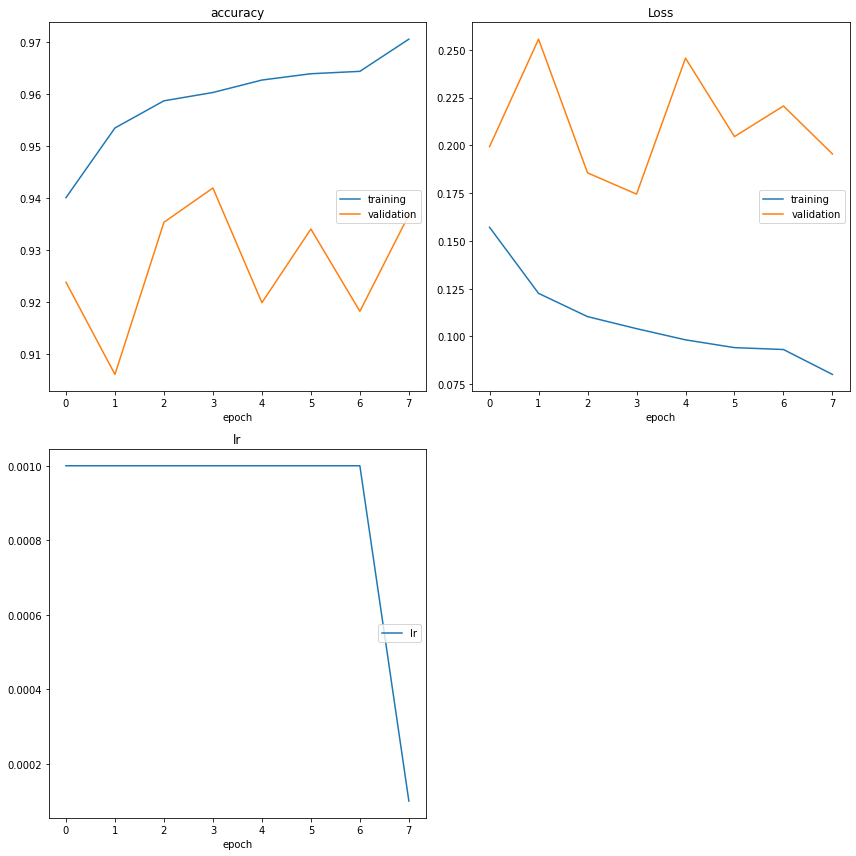

accuracy
	training         	 (min:    0.940, max:    0.971, cur:    0.971)
	validation       	 (min:    0.906, max:    0.942, cur:    0.937)
Loss
	training         	 (min:    0.080, max:    0.157, cur:    0.080)
	validation       	 (min:    0.174, max:    0.256, cur:    0.196)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
Epoch 00008: early stopping


In [21]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_data,steps_per_epoch=train_data.samples//batch_size,
                   validation_data=validation_data,
                   validation_steps=validation_data.samples//batch_size,
                   callbacks=callbacks,
                    epochs=15)

In [22]:
model.evaluate(test_data)

26/26 [==============================] - 23s 900ms/step - loss: 0.2817 - accuracy: 0.8936


[0.28173762559890747, 0.8935773968696594]

In [24]:
model.evaluate(validation_data)

128/128 [==============================] - 244s 2s/step - loss: 0.1784 - accuracy: 0.9392


[0.17843273282051086, 0.9392102956771851]

In [25]:
model.evaluate(train_data)

511/511 [==============================] - 1004s 2s/step - loss: 0.0923 - accuracy: 0.9654


[0.09225210547447205, 0.9653657674789429]